# droidlet for Physical Robots

In this tutorial, we implement an agent that takes commands from humans in natural language, and executes those commands on a physical robot.

At the end of this tutorial, you should be able to give a command ***go to the chair***, and the robot will physically go to the closest chair that it finds.


The robot that we are going to use is a [locobot](http://www.locobot.org/). It costs [$5,000](https://www.robotshop.com/en/locobot-pyrobot.html), it has an RGB + Depth camera, a wheel base and an arm. It looks like this:

<div>
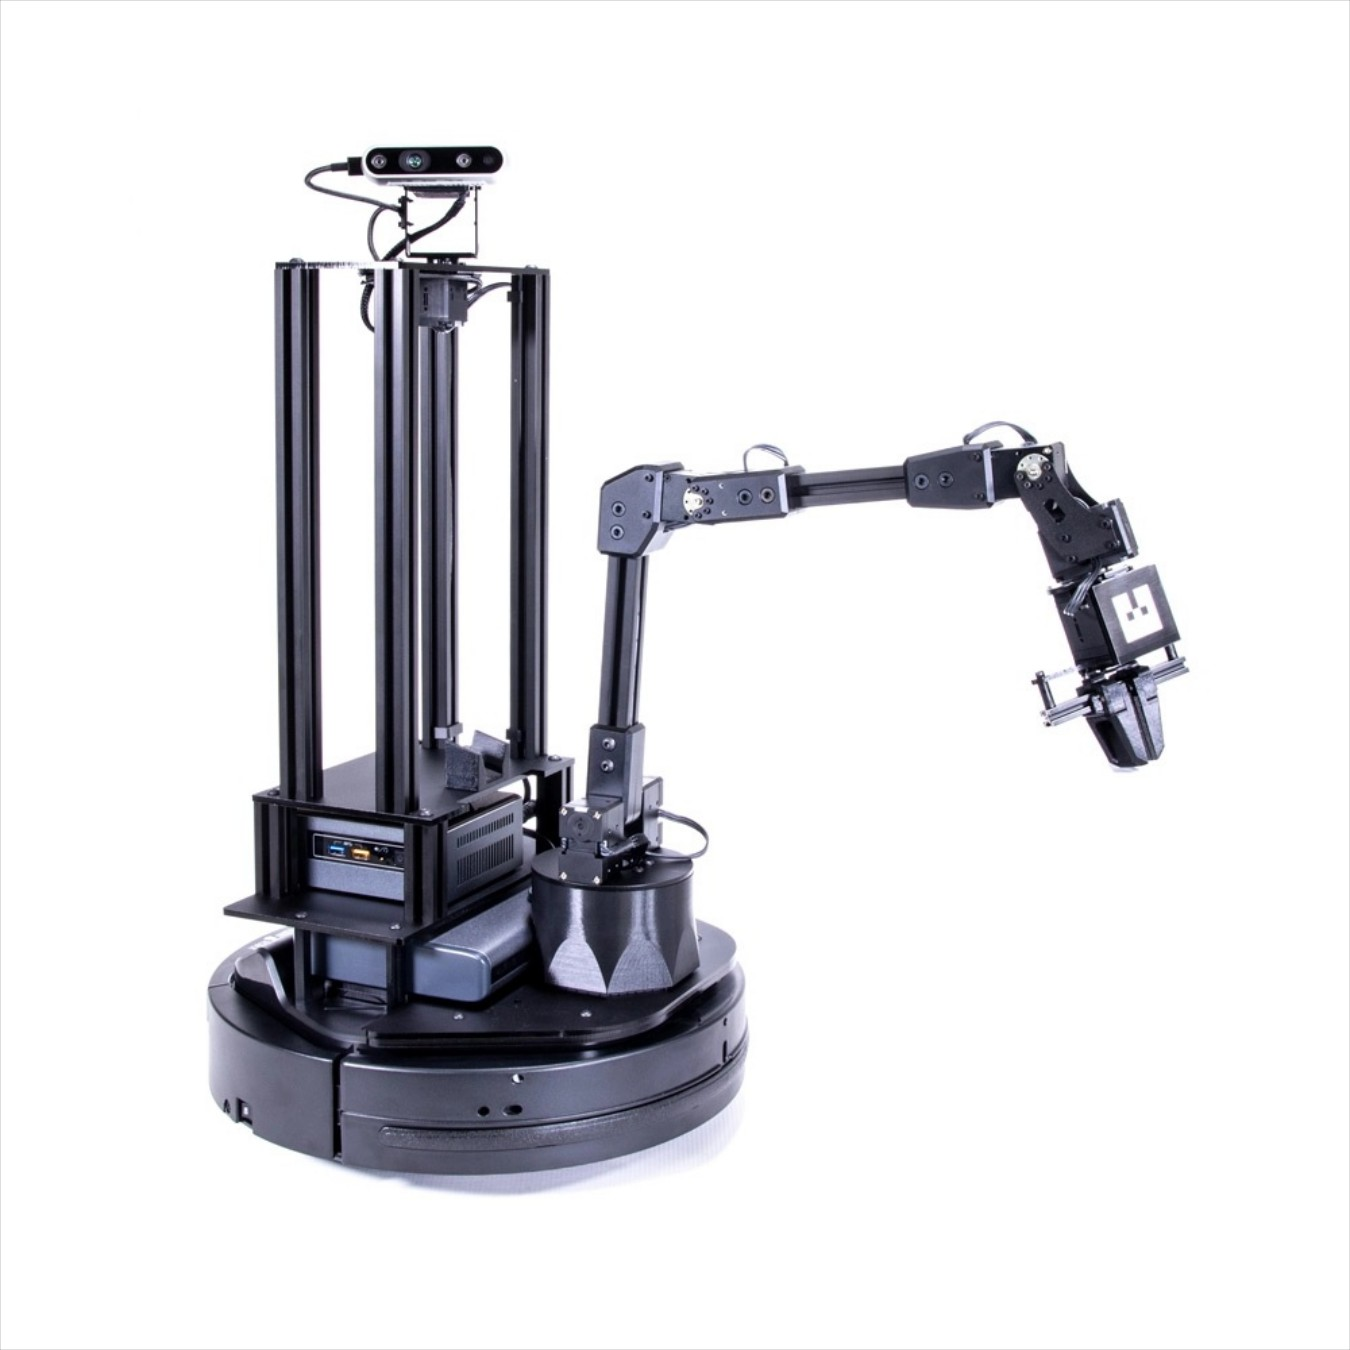
</div>

Because we don't have a locobot and don't want to spend that kind of money to do the droidlet tutorial, we use a photorealistic simulator that simulates locobot. This simulator is called [Habitat](https://aihabitat.org/). This simulator can simulate everything about the locobot except it's arm. So as an approximation, we are going to pretend that there is no arm.

## Prerequisites


1. Make sure that you have [**droidlet installed**](https://github.com/facebookresearch/droidlet#getting-started)
2. For this tutorial, we require a Linux machine with a CUDA-enabled GPU
3. We are going to use a photorealistic robot simulator called Habitat for this tutorial. For easy installation and launching of the simulator, [install Docker](https://docs.docker.com/get-docker/) on your computer.
4. From the root directory of the droidlet repository, run the command `tools/data_scripts/compare_directory_hash.sh locobot`. This downloads the relevant model artifacts for the various neural network models used by `droidlet`

Lastly, make sure that you cover the basic tutorial [How to build a Simple Agent](https://github.com/facebookresearch/droidlet/blob/main/tutorials/how_to_build_a_simple_agent.ipynb).

It introduces you to the basic set of abstractions and concepts in `droidlet`: Memory, Perception, Controller and Tasks.

## Start the Habitat simulator in the background

The one last step we need to do before we start our tutorial is to start the Habitat simulator and have it available for our agent to talk to.

Open a separate Terminal, and Follow steps 1 and 2 at this [link](https://github.com/facebookresearch/droidlet/tree/main/locobot#getting-started) to start a Habitat server.
If everything goes well, you should see a message `Server is started...` on the Terminal.

Once you see that message, come back here.

## Implementing the agent: 4 components

As a reminder from the basic tutorial, these are the steps involved in creating an agent:

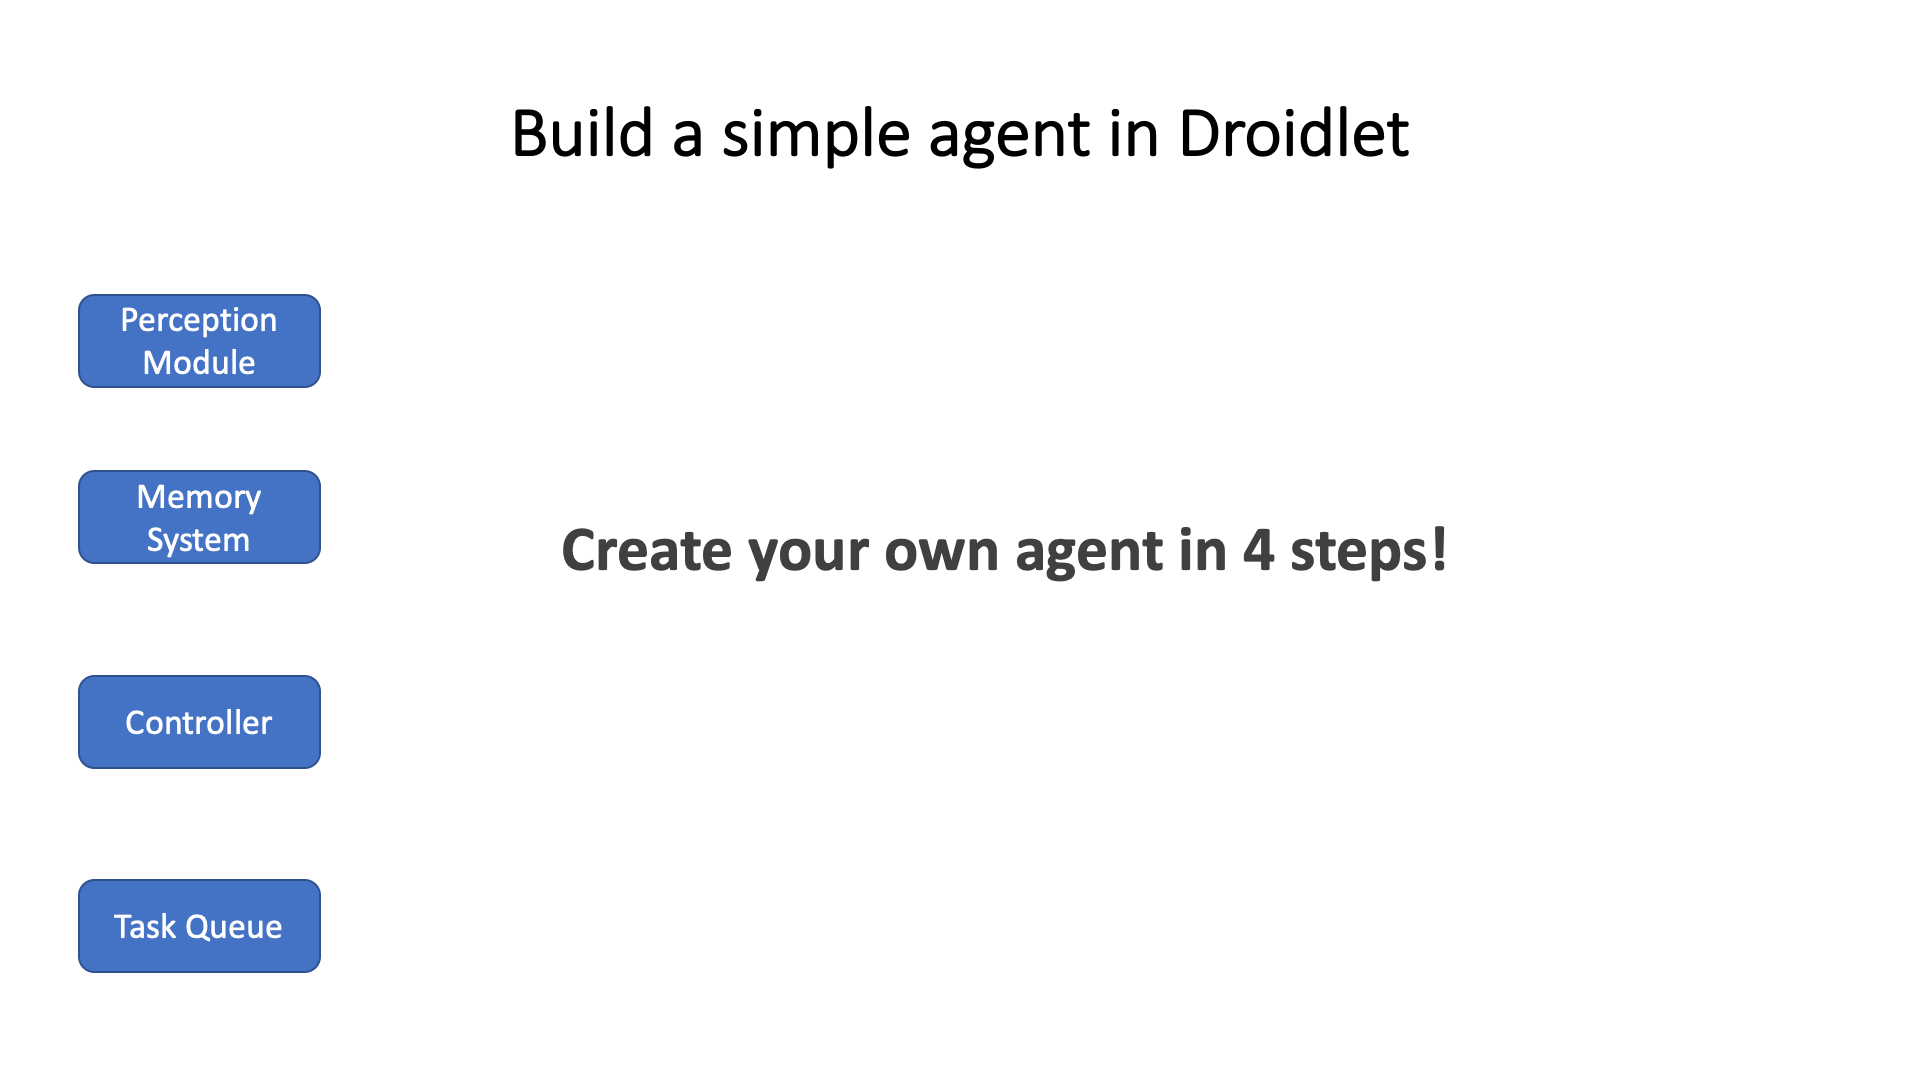

Then, the agent roughly runs the following event loop:

> **while** True **do**
>> run [perceptual modules](https://facebookresearch.github.io/droidlet/perception.html), update [memory](https://facebookresearch.github.io/droidlet/memory.html)
>>
>> step [controller](https://facebookresearch.github.io/droidlet/controller.html)
>>
>> step highest priority [task](https://facebookresearch.github.io/droidlet/tasks.html)

We divide this tutorial into 6 steps.

- Step 1: Display it's RGB and Depth sensors, move the robot manually
- Step 2: Put an object detection perception pipeline for the robot that detects objects and stores their properties and location into the agent's memory
- Step 3: Use a pre-built dialog parser that parses natural language text into a canonical intermediate representation (IR)
- Step 4: Create a small controller that converts the IR from step 1 into tasks for the robot
- Step 5: Tie all these together, display the robot sensors into a dashboard interface and test some commands

## Step 1: Display the sensors, move the robot

To display sensors, we shall use a small dashboard interface that we built as part of droidlet.
It has a few sensor display panes, some text boxes and some debugging panes that can see the internal state of the robot, including it's memory.

In [1]:
import dldashboard
dldashboard.start()
from dlevent import sio as dash

 * Serving Flask app "dldashboard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [2]:
dldashboard.display()

You can also access this dashboard in a separate browser window at [http://localhost:8000](http://localhost:8000)

When we change the state of the robot, we will observe it in this dashboard.
We can send data to this dashboard using `dash.emit` calls, as you will see below. The dashboard is bi-directional. We can get inputs from the dashboard via `@dash.on` functions that we register on specific events. Getting inputs from the dashboard is out of scope of this tutorial.

Let us first begin by creating a `LocoBotMover` object that gets a raw handle to the robot interface.

In [3]:
from locobot.agent.locobot_mover import LoCoBotMover

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
locobot = LoCoBotMover(ip="172.17.0.2", backend="habitat")

This `mover` object now gives you a raw low-level interface to the robot.
It is located [here](https://github.com/facebookresearch/droidlet/blob/main/locobot/agent/locobot_mover.py#L28) with inline docstrings.

It has functions such as `move_relative`, `move_absolute`, `turn` to move the robot, `get_base_pos` to get the robot position in world co-ordinates, `get_rgb_depth` to get the RGB-D images and a few more functions related to controlling the arm (which we shall ignore) such as `point_at`, `grab_nearby_object`, `drop` and more.

**Display camera images**

We can display the current RGB images to the dashboard with the following snippet:

In [5]:
rgbdepth = locobot.get_rgb_depth()
rgb, depth = rgbdepth.to_struct().values() # convert to a simple json-ish object

dash.emit("rgb", rgb)
dash.emit("depth", depth)
# dash.emit("sensor_payload", {"image": rgbdepth.to_struct()})

Let us make this a function for future reference

In [6]:
def display_rgbd():
    rgb, depth = locobot.get_rgb_depth().to_struct().values()
    dash.emit("rgb", rgb)
    dash.emit("depth", depth)

Now, see the dashboard above. There should be two movable and resizeable panes that display the RGB and Depth images from the robot's camera.
We are in a house with two humans, and some furniture such as chairs and sofas.

**Unsupervised Exploration**

One of the primitives that comes with locobot is to set it to an unsupervised `explore()` mode, where it goes around the environment and tries to absorb information.

Let us put the locobot in explore mode and observe the camera for 15 seconds.
Run the code below and look at the dashboard above.

In [7]:
import time
start_time = time.time()

while time.time() - start_time < 15: # run for 15 seconds
    
    # explore the environment
    locobot.explore() 
    
    # get new camera images and display them in the dashboard
    display_rgbd()
    
    time.sleep(0.3)

**Moving controls**

Let us move the robot relative to itself with manual controls.

In [8]:
rel_position = (0.1, 0.0, -0.5) # x, y, yaw
locobot.move_relative(rel_position)
display_rgbd()

## Step 2: Perception and memory for the robot

Now that we have the basic sensors, visualization and movement of the robot handled, we move on to the next step.

First, let us build the perception pipeline for the robot. We have RGB and Depth images coming out of the robot. These can be processed by computer vision models to extract semantic information about the scene.

`droidlet` [provides a few built-in modules](https://github.com/facebookresearch/droidlet/tree/main/locobot/agent/perception/handlers) to extract such semantic information. A few examples are:

- An object detector that outputs object names and their properties (such as color)
- An object tracker that tracks objects across space and time as the robot moves. This helps the robot in deduplicating object instances that it detects across frames
- A face recognizer wrapped from the open-source [dlib](http://dlib.net/) library
- A human detector along with the estimation of the detected human's pose

In this tutorial, let us use the object detector and tracker.

In [9]:
from locobot.agent.perception.handlers import DetectionHandler, TrackingHandler

The `perception` classes named `*Handler` have a very simple interface.
They have:
- a constructor `__init__` which initializes the object, loading any needed models and metadata.
- a `handle(...)` function that takes the expected input and returns the semantically processed output

The `input` expected and `output` returned by the `handle` function are documented in the docstring of the particular class.

**Object Detection**

For a little bit of fun, let us process our rgb-depth images through the `DetectionHandler` and visualize the outputs in the dashboard.

Initializing the `DetectionHandler` involves pointing it to the directory where the model weights are located.

In [10]:
import os

# path where the model weights were downloaded
model_weights_dir = os.path.abspath(os.path.join(os.getcwd(), "../", "locobot", "agent", "models", "perception"))

detector = DetectionHandler(model_weights_dir)

The `detector`'s handle here takes the `RGBDepth` object returned by the robot's `get_rgb_depth()` call, and returns the detected object locations in 3D global co-ordinates as well as their semantic properties.

For 30 frames, let us put the robot in `explore` mode, run the detector and visualize the objects in the dashboard

In [11]:
for i in range(30):
    locobot.explore()

    # get the image and process it to get the detected objects
    rgb_depth = locobot.get_rgb_depth()
    objects = detector(rgb_depth)

    # send to the dashboard for display
    dash.emit("objects", {"image": rgb_depth.to_struct(),
                   "objects": [o.to_struct() for o in objects]})

**Object Tracking and Deduplication**

The object tracker has a simple self-explanatory API. It takes objects and compares them to previously stored / tracked objects. If they are previous instances, it discards the metadata from the current objects, and merges them with the previous objects.

It then stores all of it's tracked objects (over time) in it's `.tracked_objects` property.

Let us run the object detector and tracker for a few frames, printing out the total number of objects detected, and the total unique number of objects after the tracker's de-duplication.

The tracker is able to de-duplicate the objects across multiple frames efficiently.

The tracker is powered by a great open-source library called [Norfair](https://github.com/tryolabs/norfair) from [TryoLabs](https://tryolabs.com/)

In [19]:
tracker = TrackingHandler(silent=True)


total_detections = 0
# TODO: if exploration ends, the robot is sitting at the same place in the scene without moving
for i in range(30):
    locobot.explore()

    rgb_depth = locobot.get_rgb_depth()
    objects = detector(rgb_depth)
    total_detections += len(objects)
    
    # stores object instances
    tracker(rgb_depth, objects)
    
    print("Frame {}: Total Detections: {}, De-duplicated and Unique Objects: {}".format(
        i, total_detections, len(tracker.tracked_objects)))

Frame 0: Total Detections: 4, De-duplicated and Unique Objects: 0
Frame 1: Total Detections: 8, De-duplicated and Unique Objects: 4
Frame 2: Total Detections: 12, De-duplicated and Unique Objects: 4
Frame 3: Total Detections: 16, De-duplicated and Unique Objects: 4
Frame 4: Total Detections: 20, De-duplicated and Unique Objects: 4
Frame 5: Total Detections: 24, De-duplicated and Unique Objects: 4
Frame 6: Total Detections: 28, De-duplicated and Unique Objects: 4
Frame 7: Total Detections: 32, De-duplicated and Unique Objects: 4
Frame 8: Total Detections: 36, De-duplicated and Unique Objects: 4
Frame 9: Total Detections: 40, De-duplicated and Unique Objects: 4
Frame 10: Total Detections: 44, De-duplicated and Unique Objects: 4
Frame 11: Total Detections: 48, De-duplicated and Unique Objects: 4
Frame 12: Total Detections: 52, De-duplicated and Unique Objects: 4
Frame 13: Total Detections: 56, De-duplicated and Unique Objects: 4
Frame 14: Total Detections: 60, De-duplicated and Unique Obj

**Memory**

Now we have setup a small object detection + tracking pipeline.

But the robot is not storing the information of these objects in it's memory yet.

If it doesn't store this information in memory, then when you say "go to the chair", it does not know where the chair is (unless the chair is in it's field of view at that given moment).

`droidlet` provides a memory system that can store generic metadata, and this system is used by the Dialog Parser + Task controller to do tasks properly.



## Section 1: Neural Dialog Parser

In [14]:
from base_agent.dialogue_objects import Say

# capabilities = Say(["Try asking me to go to an object",
#      "Try asking me to go to the chair"])